<a href="https://colab.research.google.com/github/41371112h/114-1/blob/main/HW3_%E5%BE%85%E8%BE%A6%E6%B8%85%E5%96%AE%E8%88%87%E7%95%AA%E8%8C%84%E9%90%98%E7%B4%80%E9%8C%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HW3待辦清單與番茄鐘紀錄**  
試算表連結：https://docs.google.com/spreadsheets/d/1JFVZqPdA1qklN_meRqspdq5jSC8xCt8eaza83ffqmX4/edit?gid=220435496#gid=220435496  
**Gradio 介面簡介**  
1️⃣ Dashboard / 視覺化  
任務完成狀態圖：顯示已完成與未完成的任務數量  
任務標籤分佈圖：顯示各類型任務（例如：工作、學習）的數量  
番茄鐘折線圖：每天完成的番茄鐘分鐘數（互動式圖）  
點「生成統計圖」就會更新圖表  
2️⃣ 新增 / 更新 任務  
用來建立或修改待辦事項 ：  
填寫任務名稱、描述、優先度、到期日、標籤  
勾選「標記完成」可直接設為已完成  
點「Save」後會儲存在試算表中  
📌 如果輸入現有任務 ID = 更新任務 / 留空 = 新增任務  
3️⃣ 番茄鐘紀錄  
用來記錄你專注的時間段 🕒：  
選擇任務  
設定分鐘數（預設 25 分鐘）  
可以加上開始/結束時間與備註  
點「新增番茄鐘紀錄」 → 會寫入試算表的 Logs 頁  
也可以點「將選擇的任務標記完成」✅  
4️⃣ 刪除任務  
刪除你不再需要的任務：  
下拉選單選任務  
勾選「同時刪除相關紀錄」會把該任務在 Logs 裡的資料也刪掉  
點「刪除」 → 試算表資料立即更新  
5️⃣ 查詢強化  
用來篩選或查詢特定任務 ：  
選擇 完成狀態（全部 / 已完成 / 未完成）
指定 日期欄位（建立日 / 到期日 / 完成日）
輸入起訖日期（可空）  
可輸入標籤關鍵字（如「報告」）   
點「查詢」後會在下方顯示符合條件的任務表格  
6️⃣ 匯入 / 匯出  
匯出或匯入你的資料檔案 ：
匯出（CSV/JSON）：  
產生 tasks_xxx.csv/json、logs_xxx.csv/json 檔案  
👉 可從 Colab 左側 📁 下載  
匯入：
選擇要上傳的檔案（CSV 或 JSON），會覆蓋目前記憶體中的資料  
👉 想同步到試算表，要再按「Push 覆蓋到 Google Sheet」  
☁️ 上方兩個主要按鈕  
在畫面最上方會看到兩顆藍色按鈕：  
按鈕功能  
Pull 從 Google Sheet	從你的雲端試算表載入最新資料  
Push 覆蓋到 Google Sheet	把目前的資料（Tasks、Logs）同步回雲端  

In [1]:
!pip install -q pandas python-dateutil pytz gspread google-auth google-auth-oauthlib gradio seaborn plotly matplotlib

In [5]:
import os, json, uuid
from datetime import datetime, timedelta
from dateutil import parser as dtparser
from dateutil.tz import gettz
from typing import List, Dict, Optional
import pandas as pd
import numpy as np

# Google Colab OAuth + gspread
from google.colab import auth as colab_auth
import gspread
from google.auth import default as google_auth_default

# 視覺化 & UI
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import gradio as gr

# ========= 你的完整 Google 試算表連結（直接用 URL）=========
SPREADSHEET_URL = "https://docs.google.com/spreadsheets/d/1JFVZqPdA1qklN_meRqspdq5jSC8xCt8eaza83ffqmX4/edit?gid=0#gid=0"
TASKS_SHEET = "Tasks"
LOGS_SHEET  = "Logs"

# ========= 時區 =========
TZ = gettz("Asia/Taipei")
NOW = lambda: datetime.now(tz=TZ)

# ========= Google OAuth（Colab 內建）=========
colab_auth.authenticate_user()
creds, _ = google_auth_default(scopes=[
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
])
gc = gspread.authorize(creds)

def open_or_create_worksheet(sh, name: str, header: List[str]):
    try:
        ws = sh.worksheet(name)
    except gspread.exceptions.WorksheetNotFound:
        ws = sh.add_worksheet(title=name, rows=1000, cols=len(header))
        ws.append_row(header)
    # 校正表頭
    if ws.row_values(1) != header:
        ws.update("1:1", [header])
    return ws

def sheet_client_and_ws():
    # 直接用網址開啟，不用 ID
    sh = gc.open_by_url(SPREADSHEET_URL)
    tasks_ws = open_or_create_worksheet(sh, TASKS_SHEET, [
        "id","title","description","priority","due_date","created_at",
        "completed","completed_at","tags"
    ])
    logs_ws = open_or_create_worksheet(sh, LOGS_SHEET, [
        "id","task_id","duration_min","start_time","end_time","notes"
    ])
    return sh, tasks_ws, logs_ws

# ========= In-memory 結構（list + dict）=========
class Store:
    def __init__(self):
        self.tasks: List[Dict] = []
        self.logs:  List[Dict] = []
        self.task_by_id: Dict[str, Dict] = {}
        self.logs_by_id: Dict[str, Dict] = {}
    def rebuild_index(self):
        self.task_by_id = {t["id"]: t for t in self.tasks}
        self.logs_by_id = {l["id"]: l for l in self.logs}

STORE = Store()

# ========= 小工具 =========
def iso_or_empty(s: str) -> str:
    if not s: return ""
    try:
        return dtparser.parse(s).astimezone(TZ).isoformat()
    except:
        return ""

def parse_date(s: str):
    if not s: return None
    try:
        return dtparser.parse(s).astimezone(TZ)
    except:
        return None

def tasks_df() -> pd.DataFrame:
    cols = ["id","title","description","priority","due_date","created_at","completed","completed_at","tags"]
    return pd.DataFrame(STORE.tasks, columns=cols)

def logs_df() -> pd.DataFrame:
    cols = ["id","task_id","duration_min","start_time","end_time","notes"]
    return pd.DataFrame(STORE.logs, columns=cols)

# ========= Google Sheets 同步 =========
def pull_from_google_sheets():
    try:
        _, t_ws, l_ws = sheet_client_and_ws()
        t_records = t_ws.get_all_records()
        l_records = l_ws.get_all_records()

        def b(x):
            if isinstance(x, bool): return x
            s = str(x).strip().lower()
            return s in ("true","1","yes","y","完成","已完成")

        def ts(x):
            if not x: return ""
            try:
                return dtparser.parse(str(x)).astimezone(TZ).isoformat()
            except:
                return str(x)

        tasks = []
        for r in t_records:
            tasks.append({
                "id": str(r.get("id") or str(uuid.uuid4())),
                "title": r.get("title","").strip(),
                "description": r.get("description",""),
                "priority": int(r.get("priority") or 0),
                "due_date": ts(r.get("due_date")),
                "created_at": ts(r.get("created_at")) or NOW().isoformat(),
                "completed": b(r.get("completed")),
                "completed_at": ts(r.get("completed_at")),
                "tags": str(r.get("tags","")).strip()
            })

        logs = []
        for r in l_records:
            logs.append({
                "id": str(r.get("id") or str(uuid.uuid4())),
                "task_id": str(r.get("task_id","")).strip(),
                "duration_min": int(r.get("duration_min") or 25),
                "start_time": ts(r.get("start_time")),
                "end_time": ts(r.get("end_time")),
                "notes": r.get("notes","")
            })

        STORE.tasks, STORE.logs = tasks, logs
        STORE.rebuild_index()
        return f"✅ 已載入 Tasks: {len(tasks)}，Logs: {len(logs)}"
    except Exception as e:
        return f"❌ 讀取失敗：{type(e).__name__}: {e}"

def push_to_google_sheets():
    try:
        _, t_ws, l_ws = sheet_client_and_ws()
        t_df, l_df = tasks_df(), logs_df()
        # 清空（保留表頭）
        if t_ws.row_count > 1: t_ws.resize(rows=1)
        if l_ws.row_count > 1: l_ws.resize(rows=1)
        if not t_df.empty: t_ws.append_rows(t_df.fillna("").astype(str).values.tolist())
        if not l_df.empty: l_ws.append_rows(l_df.fillna("").astype(str).values.tolist())
        return f"☁️ 已覆蓋：Tasks({len(t_df)}), Logs({len(l_df)})"
    except Exception as e:
        return f"❌ 寫入失敗：{type(e).__name__}: {e}"

def delete_task_in_sheet(task_id: str, also_delete_logs: bool=False):
    try:
        _, t_ws, l_ws = sheet_client_and_ws()
        t_vals = t_ws.get_all_values()
        if not t_vals or len(t_vals) < 2:
            return "Tasks 表沒有資料"
        header = t_vals[0]
        if "id" not in header: return "Tasks 表頭缺少 id 欄"
        id_idx = header.index("id")

        target_row = None
        for i, row in enumerate(t_vals[1:], start=2):
            if len(row) > id_idx and row[id_idx] == task_id:
                target_row = i
                break
        if not target_row:
            return f"找不到任務 id={task_id}"

        t_ws.delete_rows(target_row)

        # in-memory 一併刪除
        STORE.tasks = [t for t in STORE.tasks if t["id"] != task_id]

        if also_delete_logs:
            l_vals = l_ws.get_all_values()
            if l_vals and len(l_vals) >= 2:
                l_header = l_vals[0]
                if "task_id" in l_header:
                    task_idx = l_header.index("task_id")
                    rows = [i for i, row in enumerate(l_vals[1:], start=2)
                            if len(row) > task_idx and row[task_idx] == task_id]
                    for r in sorted(rows, reverse=True):
                        l_ws.delete_rows(r)
            STORE.logs = [l for l in STORE.logs if l["task_id"] != task_id]

        STORE.rebuild_index()
        return f"🗑️ 已刪除任務 {task_id}" + ("，並刪相關紀錄" if also_delete_logs else "")
    except Exception as e:
        return f"❌ 刪除失敗：{type(e).__name__}: {e}"

# ========= CRUD / 查詢 =========
def add_or_update_task(task_id: Optional[str], title: str, description: str, priority: int,
                       due_date_str: str, tags: str, completed: bool):
    if task_id and task_id.strip():
        tid = task_id.strip()
        t = STORE.task_by_id.get(tid)
        if not t: return f"找不到任務 id={tid}"
        t["title"] = title.strip()
        t["description"] = description
        t["priority"] = int(priority or 0)
        t["due_date"] = iso_or_empty(due_date_str)
        t["tags"] = tags.strip()
        if completed and not t["completed"]:
            t["completed"] = True
            t["completed_at"] = NOW().isoformat()
        elif not completed:
            t["completed"] = False
            t["completed_at"] = ""
        msg = f"✏️ 已更新任務 {tid}"
    else:
        tid = str(uuid.uuid4())
        new_task = {
            "id": tid,
            "title": title.strip(),
            "description": description,
            "priority": int(priority or 0),
            "due_date": iso_or_empty(due_date_str),
            "created_at": NOW().isoformat(),
            "completed": bool(completed),
            "completed_at": NOW().isoformat() if completed else "",
            "tags": tags.strip()
        }
        STORE.tasks.append(new_task)
        msg = f"🆕 已新增任務 {tid}"
    STORE.rebuild_index()
    return msg

def add_log(task_choice: str, duration_min: int, start_time: str, end_time: str, notes: str):
    if not task_choice:
        return "請先選擇任務"
    task_id = task_choice.split("|")[0].strip()
    if task_id not in STORE.task_by_id:
        return f"無此任務 id={task_id}"
    lid = str(uuid.uuid4())
    log = {
        "id": lid,
        "task_id": task_id,
        "duration_min": int(duration_min or 25),
        "start_time": iso_or_empty(start_time) or NOW().isoformat(),
        "end_time": iso_or_empty(end_time) or (datetime.now(tz=TZ) + timedelta(minutes=int(duration_min or 25))).isoformat(),
        "notes": notes or ""
    }
    STORE.logs.append(log)
    STORE.rebuild_index()
    return f"⏱️ 已新增番茄鐘紀錄 {lid}"

def complete_task(task_choice: str):
    if not task_choice: return "請先選擇任務"
    task_id = task_choice.split("|")[0].strip()
    t = STORE.task_by_id.get(task_id)
    if not t: return f"找不到任務 id={task_id}"
    t["completed"] = True
    if not t.get("completed_at"):
        t["completed_at"] = NOW().isoformat()
    STORE.rebuild_index()
    return f"✅ 任務 {task_id} 已標記完成"

def query_tasks(completed_filter: str, range_field: str, start: str, end: str, tag_keyword: str) -> pd.DataFrame:
    df = tasks_df().copy()
    if df.empty: return df
    # 完成狀態
    if completed_filter == "已完成":
        df = df[df["completed"] == True]
    elif completed_filter == "未完成":
        df = df[df["completed"] == False]
    # 日期範圍
    if range_field and range_field in df.columns:
        sdt = parse_date(start) if start else None
        edt = parse_date(end) if end else None
        df[range_field] = pd.to_datetime(df[range_field], errors="coerce")
        if sdt is not None: df = df[df[range_field] >= sdt]
        if edt is not None: df = df[df[range_field] <= edt]
    # 標籤關鍵字
    if tag_keyword:
        df = df[df["tags"].astype(str).str.contains(tag_keyword, case=False, na=False)]
    return df.fillna("")

# ========= 匯出 / 匯入（本地檔案，不上傳 GitHub）=========
def export_to_files():
    ts = datetime.now(tz=TZ).strftime("%Y%m%d_%H%M%S")
    t_csv, l_csv = f"tasks_{ts}.csv", f"logs_{ts}.csv"
    t_json, l_json = f"tasks_{ts}.json", f"logs_{ts}.json"
    tasks_df().to_csv(t_csv, index=False, encoding="utf-8-sig")
    logs_df().to_csv(l_csv, index=False, encoding="utf-8-sig")
    tasks_df().to_json(t_json, orient="records", force_ascii=False, indent=2)
    logs_df().to_json(l_json, orient="records", force_ascii=False, indent=2)
    return f"✅ 已匯出本地檔案：\n- {t_csv}\n- {l_csv}\n- {t_json}\n- {l_json}\n（Colab 左側檔案樹可直接下載）"

def import_from_file(file_obj, file_type: str):
    try:
        if file_obj is None:
            return "請選擇檔案"
        if file_type == "tasks_csv":
            df = pd.read_csv(file_obj.name)
            STORE.tasks = df.fillna("").to_dict(orient="records")
        elif file_type == "logs_csv":
            df = pd.read_csv(file_obj.name)
            STORE.logs = df.fillna("").to_dict(orient="records")
        elif file_type == "tasks_json":
            data = json.load(open(file_obj.name, "r", encoding="utf-8"))
            STORE.tasks = data
        elif file_type == "logs_json":
            data = json.load(open(file_obj.name, "r", encoding="utf-8"))
            STORE.logs = data
        else:
            return "未知匯入類型"
        STORE.rebuild_index()
        return f"✅ 匯入完成（{file_type}）— 如要寫回雲端，請再按 Push。"
    except Exception as e:
        return f"❌ 匯入失敗：{type(e).__name__}: {e}"

# ========= 視覺化 =========
def plot_summary():
    # 1) 任務完成 vs 未完成（seaborn）
    tdf = tasks_df()
    plt.figure()
    if tdf.empty:
        plt.title("No Task Data")
    else:
        tdf2 = tdf.copy()
        tdf2["status"] = np.where(tdf2["completed"]==True, "Completed", "Open")
        sns.countplot(data=tdf2, x="status")
        plt.title("Tasks Status Count")
    fig1 = plt.gcf()

    # 2) 各標籤任務數（seaborn）
    plt.figure()
    if tdf.empty:
        plt.title("No Tags")
    else:
        tags_series = []
        for _, row in tdf.iterrows():
            tags = [t.strip() for t in str(row.get("tags","")).split(",") if t.strip()]
            tags_series.extend(tags)
        if tags_series:
            df_tags = pd.DataFrame({"tag": tags_series})
            sns.countplot(data=df_tags, y="tag", order=df_tags["tag"].value_counts().index)
            plt.title("Tasks by Tag")
        else:
            plt.title("No Tags")
    fig2 = plt.gcf()

    # 3) 每日番茄鐘分鐘數（plotly）
    ldf = logs_df()
    if ldf.empty:
        html = "<h3>No Log Data</h3>"
    else:
        ldf2 = ldf.copy()
        ldf2["start_date"] = pd.to_datetime(ldf2["start_time"], errors="coerce").dt.date
        agg = ldf2.groupby("start_date", dropna=True)["duration_min"].sum().reset_index()
        fig = px.line(agg, x="start_date", y="duration_min", title="Pomodoro Minutes by Day")
        html = fig.to_html(include_plotlyjs="cdn", full_html=False)

    return fig1, fig2, html

# ========= Gradio 事件 =========
def ui_pull():
    msg = pull_from_google_sheets()
    choices = [f'{t["id"]} | {t["title"]}' for t in STORE.tasks]
    return msg, gr.update(choices=choices), gr.update(choices=choices)

def ui_push():
    return push_to_google_sheets()

def ui_add_update_task(task_id, title, desc, priority, due_date, tags, completed):
    msg = add_or_update_task(task_id, title, desc, priority, due_date, tags, completed)
    choices = [f'{t["id"]} | {t["title"]}' for t in STORE.tasks]
    return msg, gr.update(choices=choices), gr.update(choices=choices)

def ui_add_log(task_choice, duration_min, start_time, end_time, notes):
    return add_log(task_choice, duration_min, start_time, end_time, notes)

def ui_complete_task(task_choice):
    return complete_task(task_choice)

def ui_delete_task(task_choice, also_logs):
    if not task_choice: return "請先選擇任務", gr.update(), gr.update()
    task_id = task_choice.split("|")[0].strip()
    msg = delete_task_in_sheet(task_id, also_delete_logs=also_logs)
    _ = pull_from_google_sheets()
    choices = [f'{t["id"]} | {t["title"]}' for t in STORE.tasks]
    return msg, gr.update(choices=choices), gr.update(choices=choices)

def ui_export():
    return export_to_files()

def ui_import(file_obj, file_type):
    return import_from_file(file_obj, file_type)

def ui_query(completed_filter, range_field, start, end, tag_keyword):
    df = query_tasks(completed_filter, range_field, start, end, tag_keyword)
    if df.empty:
        return "（沒有符合條件的資料）"
    return df.to_markdown(index=False)

def ui_plot():
    fig1, fig2, html = plot_summary()
    return fig1, fig2, html

# ========= Gradio 介面 =========
with gr.Blocks(title="待辦清單＋番茄鐘", theme=gr.themes.Soft()) as demo:
    gr.Markdown("## 待辦清單＋番茄鐘")

    with gr.Row():
        btn_pull = gr.Button("Pull 從 Google Sheet")
        btn_push = gr.Button("Push 覆蓋到 Google Sheet")
    out_sync = gr.Textbox(label="同步狀態", interactive=False)

    with gr.Tab("Dashboard / 視覺化"):
        btn_plot = gr.Button("生成統計圖")
        img1 = gr.Plot(label="任務完成狀態（seaborn）")
        img2 = gr.Plot(label="各標籤任務數（seaborn）")
        html3 = gr.HTML(label="每日番茄鐘分鐘數（plotly）")
        btn_plot.click(ui_plot, outputs=[img1, img2, html3])

    with gr.Tab("新增 / 更新 任務"):
        t_task_id = gr.Textbox(label="任務ID（留空=新增）")
        t_title   = gr.Textbox(label="標題")
        t_desc    = gr.Textbox(label="描述")
        t_priority= gr.Slider(0, 5, value=0, step=1, label="優先度")
        t_due     = gr.Textbox(label="到期日（YYYY-MM-DD 或自然語言）")
        t_tags    = gr.Textbox(label="標籤（逗號分隔）")
        t_completed = gr.Checkbox(label="標記完成", value=False)
        btn_save  = gr.Button("Save（新增/更新）")
        out_save  = gr.Textbox(label="結果", interactive=False)

    with gr.Tab("番茄鐘紀錄"):
        task_select = gr.Dropdown(choices=[], label="選擇任務（新增紀錄 / 完成）")
        duration = gr.Slider(5, 120, value=25, step=5, label="分鐘")
        start_time = gr.Textbox(label="開始時間（空白=現在）")
        end_time   = gr.Textbox(label="結束時間（空白=開始+duration）")
        notes      = gr.Textbox(label="備註")
        btn_add_log = gr.Button("新增番茄鐘紀錄")
        out_add_log = gr.Textbox(label="紀錄結果", interactive=False)
        btn_complete = gr.Button("將選擇的任務標記完成")
        out_complete = gr.Textbox(label="完成結果", interactive=False)

    with gr.Tab("刪除任務"):
        task_select_del = gr.Dropdown(choices=[], label="選擇要刪除的任務")
        also_logs = gr.Checkbox(label="同時刪除相關紀錄（Logs）", value=False)
        btn_delete = gr.Button("刪除")
        out_delete = gr.Textbox(label="刪除結果", interactive=False)

    with gr.Tab("查詢強化"):
        completed_filter = gr.Radio(["全部","已完成","未完成"], value="全部", label="完成狀態")
        range_field = gr.Dropdown(["created_at","due_date","completed_at"], value="due_date", label="時間欄位")
        q_start = gr.Textbox(label="開始日期（可空）")
        q_end   = gr.Textbox(label="結束日期（可空）")
        q_tag   = gr.Textbox(label="標籤關鍵字（可空）")
        btn_query = gr.Button("查詢")
        out_query = gr.Textbox(label="結果（Markdown 表格）", lines=15)

    with gr.Tab("匯入 / 匯出"):
        btn_export = gr.Button("匯出（CSV/JSON）")
        out_export = gr.Textbox(label="匯出結果", interactive=False)

        file_type = gr.Radio(["tasks_csv","logs_csv","tasks_json","logs_json"], value="tasks_csv", label="匯入類型")
        file_u = gr.File(label="選擇檔案")
        btn_import = gr.Button("匯入（覆蓋 in-memory）")
        out_import = gr.Textbox(label="匯入結果", interactive=False)

    # 綁定
    btn_pull.click(ui_pull, outputs=[out_sync, task_select, task_select_del])
    btn_push.click(ui_push, outputs=[out_sync])

    btn_save.click(ui_add_update_task,
                   inputs=[t_task_id, t_title, t_desc, t_priority, t_due, t_tags, t_completed],
                   outputs=[out_save, task_select, task_select_del])

    btn_add_log.click(ui_add_log, inputs=[task_select, duration, start_time, end_time, notes], outputs=[out_add_log])
    btn_complete.click(ui_complete_task, inputs=[task_select], outputs=[out_complete])

    btn_delete.click(ui_delete_task, inputs=[task_select_del, also_logs], outputs=[out_delete, task_select, task_select_del])

    btn_query.click(ui_query, inputs=[completed_filter, range_field, q_start, q_end, q_tag], outputs=[out_query])

    btn_export.click(ui_export, outputs=[out_export])

    # 初始載入：讓下拉選單有資料
    demo.load(ui_pull, outputs=[out_sync, task_select, task_select_del])

# Colab 建議 share=True 以便外部打開
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4fb1a806ea9b7f4e89.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


**執行結果**
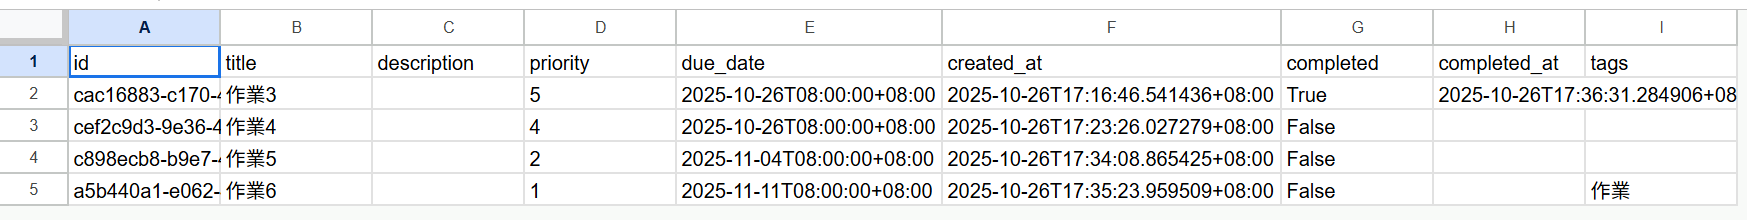  
**視覺化統計資料**  
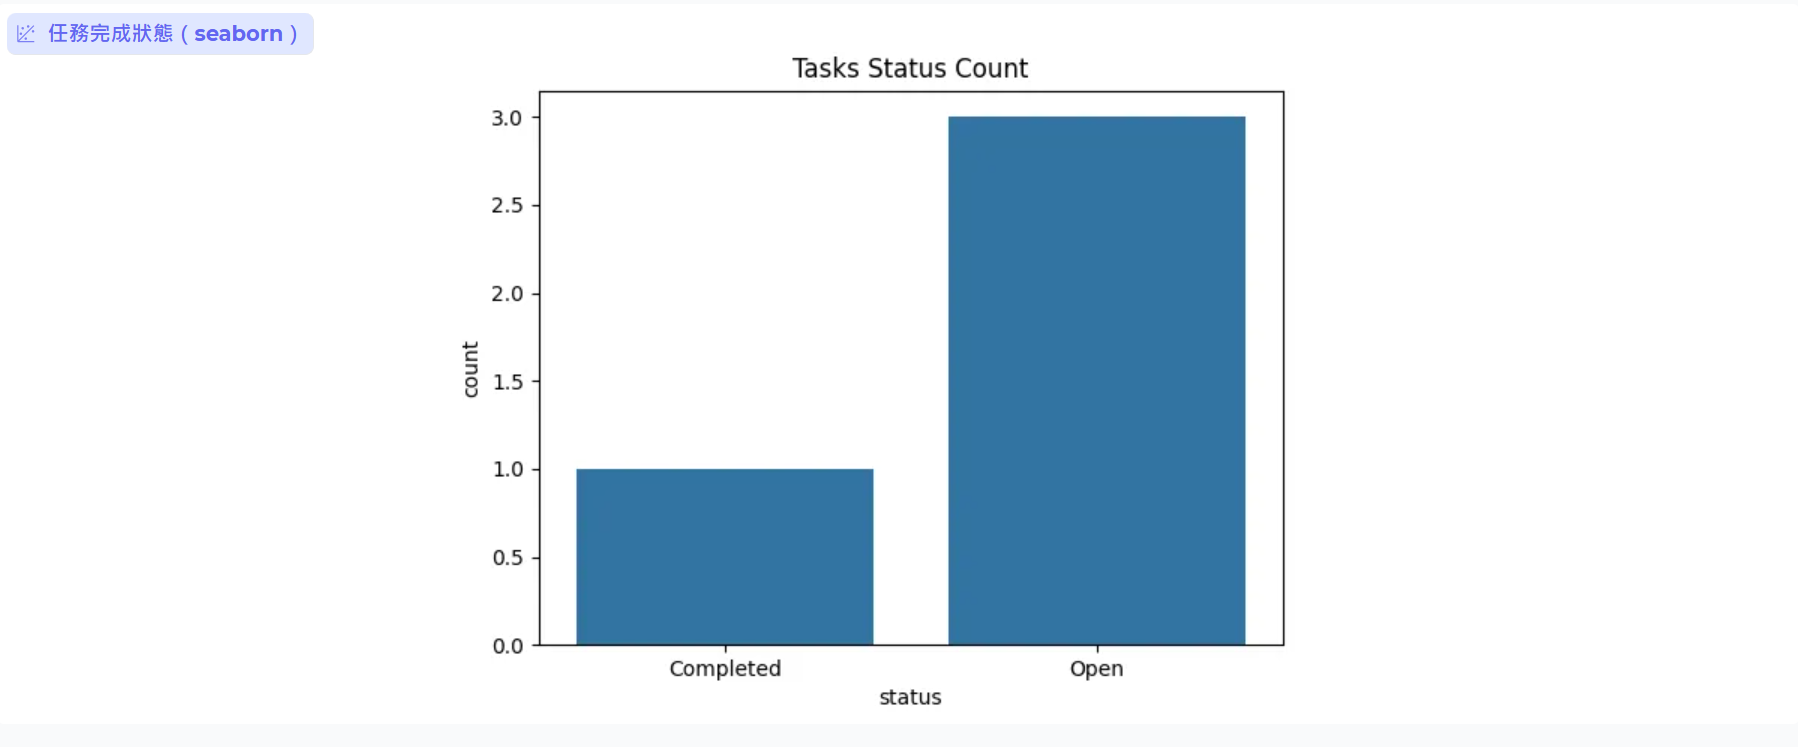